In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import average_precision_score
import pandas as pd
import numpy as np
from copy import deepcopy
import seaborn as sns
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc, precision_score, recall_score


2023-01-29 11:09:47.382837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 11:09:47.441919: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-29 11:09:47.443918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-01-29 11:09:47.443925:

### Loading Data + Visualization

In [51]:
df = pd.read_csv('./robot_data/merged_robot_data.csv')
# df = pd.read_csv('./robot_data/ep4_new.csv')
# df = pd.read_csv('./data_collection4/paired_errors.csv')

In [52]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 't', 'x', 'y', 'z', 'rx',
       'ry', 'rz', 'vx', 'vy', 'vz', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz',
       'Case'],
      dtype='object')

In [53]:
df.shape

(34745, 20)

In [54]:
df = df.drop(['Unnamed: 0.2', 'Unnamed: 0.1','Unnamed: 0','t'], axis=1)
# df = df.drop(['Unnamed: 0.1','Unnamed: 0','t'], axis=1)
# df = df.drop(['Unnamed: 0','t'], axis=1)


In [55]:
df.columns

Index(['x', 'y', 'z', 'rx', 'ry', 'rz', 'vx', 'vy', 'vz', 'Fx', 'Fy', 'Fz',
       'Mx', 'My', 'Mz', 'Case'],
      dtype='object')

In [56]:
tot = len(df.Case)
pos = df.Case.sum()
neg = tot-pos
print('Total data: ', tot)
print(f'Label: 0 {neg} | {(neg/tot)*100}%')
print(f'Label: 1 {pos} | {(pos/tot)*100}%')

Total data:  34745
Label: 0 34217 | 98.48035688588286%
Label: 1 528 | 1.5196431141171391%


In [57]:
df.describe()

,x,y,z,rx,ry,rz,vx,vy,vz,Fx,Fy,Fz,Mx,My,Mz
count,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,3.474500e+04,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000
mean,-0.137966,-0.509645,0.072540,-0.000062,-0.000266,0.001135,-0.000007,4.485801e-07,-0.000020,-0.466363,-0.188707,5.003231,-0.002840,-0.014376,0.011366
std,0.002993,0.002702,0.000078,0.001407,0.001430,0.006047,0.001145,1.248120e-03,0.000625,0.844692,1.023472,1.060861,0.108421,0.110534,0.102389
min,-0.144851,-0.515805,0.068121,-0.008628,-0.006530,-0.013364,-0.004638,-5.861016e-03,-0.025025,-3.024711,-6.715337,-0.717291,-0.826048,-0.898659,-0.215748
25%,-0.140047,-0.511618,0.072527,-0.001062,-0.001349,-0.005011,-0.001098,-1.072139e-03,-0.000156,-1.151795,-0.969887,4.606718,-0.086393,-0.099607,-0.047053
50%,-0.137905,-0.509668,0.072543,-0.000021,-0.000186,0.003569,-0.000003,-4.891891e-05,-0.000008,-0.503131,-0.010727,4.985373,0.011002,-0.014019,0.002537
75%,-0.135854,-0.507637,0.072558,0.001097,0.000907,0.006200,0.001057,1.091175e-03,0.000143,0.186419,0.621021,5.389545,0.090412,0.079033,0.109472
max,-0.131514,-0.503526,0.072718,0.002464,0.002585,0.013388,0.003001,5.903866e-03,0.004628,3.948064,2.862133,11.506700,0.201487,0.256065,0.229611


In [58]:
# corr = df.corr()
# plt.figure(figsize=(15,10))
# sns.heatmap(corr,annot=True)
# plt.show()

In [59]:
# corr_with_case = corr['Case']
# # delete .abs() if we do not want abs values
# sorted_corr = corr_with_case.abs().sort_values(ascending=False)

# corr_df = pd.DataFrame(sorted_corr)

# # rename the column
# corr_df = corr_df.rename(columns={'case': 'correlation'})

In [60]:
# corr_df

### Data Preprocessing

In [61]:
feature_names = ['Fx', 'Fy', 'Fz', 'Mx', 'My']
# feature_names = ['fz']
# 
# feature_names = ['fx', 'fy', 'fz', 'mx', 'my']

X_df = df[feature_names]
X = X_df.to_numpy()
y = df.Case.to_numpy()

window_len = 100

if window_len:
    n_features = len(feature_names)  # 3

    row = X.shape[0] + 1 - window_len
    col_len = n_features * window_len
    new_x = np.zeros((row, col_len))
    new_y = np.zeros((row, 1))

    for i in range(len(new_x)):
        new_x[i] = X[i:i + window_len].reshape(1, col_len)[0][::-1]
        new_y[i] = y[i + (window_len - 1)]

    y = deepcopy(new_y)
    X = deepcopy(new_x)

total = len(y)
pos = int(y.sum())
neg = total - pos
weight = neg/pos # 13.5

In [62]:
X_df.describe()

,Fx,Fy,Fz,Mx,My
count,34745.000000,34745.000000,34745.000000,34745.000000,34745.000000
mean,-0.466363,-0.188707,5.003231,-0.002840,-0.014376
std,0.844692,1.023472,1.060861,0.108421,0.110534
min,-3.024711,-6.715337,-0.717291,-0.826048,-0.898659
25%,-1.151795,-0.969887,4.606718,-0.086393,-0.099607
50%,-0.503131,-0.010727,4.985373,0.011002,-0.014019
75%,0.186419,0.621021,5.389545,0.090412,0.079033
max,3.948064,2.862133,11.506700,0.201487,0.256065


In [63]:
X.shape

(34646, 500)

In [64]:
print(f"Total Dataset size: {X.shape}")
print(f"Ratio of 1's in dataset {(pos/total) * 100}% and count is: {pos}")
print(f"Ratio of 0's in dataset {(neg/total) * 100}% and count is: {neg}")

Total Dataset size: (34646, 500)
Ratio of 1's in dataset 1.5239854528661316% and count is: 528
Ratio of 0's in dataset 98.47601454713387% and count is: 34118


### Helper Functions

In [65]:
def plot_prc_and_roc(y_true, y_pred):

    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    plt.figure()
    plt.step(recalls, precisions, color='b', alpha=1.0, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.1, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.grid()

    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
              average_precision))
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
            Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()       


In [66]:
def plot_precision_recall_vs_threshold(y_true, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    f1_vec = 2 * (precisions * recalls) / (precisions + recalls)
    plt.figure()
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.plot(thresholds, f1_vec[:-1], "k-", label='F1')
    plt.xlabel('Threshold')
    plt.title('Precision/ Recall/ F1 Score/ Threshold')
    plt.legend()
    plt.grid()
    plt.show()

In [67]:
def dnn_stratified_kfold_cross_val(X, y, epoch, batch_size, callback, print_info, metrics):
    """
    StratifiedKFold cross-validation. 
    """
    skf = StratifiedKFold(n_splits=10, shuffle=False)
    aucpr_scores = []
    roc_scores = []
    prec_scores =  []
    recall_scores = []

    for fold_id, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold_id}:")
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if print_info:
            print(f"Ratio of 1's in train set {np.round((y_train.sum())/len(y_train),4) * 100}%")
            print(f"Ratio of 1's in validation set {np.round((y_valid.sum()/len(y_valid)),4) * 100}%")
        
        n_inputs = X_train.shape[1]  
        # make model
        model = make_model(n_inputs, metrics=metrics)
        # fit model
        model_history = model.fit(X_train, y_train,
                          validation_data = (X_valid, y_valid),
                          epochs=epoch,
                          batch_size=batch_size,
                          verbose=0, # 1 
                          callbacks=[callback],
                          shuffle=True) 
        
        y_val_pred = model.predict(X_valid)
        roc = roc_auc_score(y_valid, y_val_pred)
        aucpr = average_precision_score(y_valid, y_val_pred)
        prec = precision_score(y_valid, y_val_pred > 0.5)
        recall = recall_score(y_valid, y_val_pred > 0.5)
        if print_info:
            print('--------------------------------------')
            print(f"Aucpr score for fold {fold_id} is : {aucpr}")
            print(f"ROC score for fold {fold_id} is : {roc}")
            print(f"Precision  : {prec}")
            print(f"Recall : {recall}")
            print('--------------------------------------')

        aucpr_scores.append(aucpr)
        roc_scores.append(roc)
        prec_scores.append(prec)
        recall_scores.append(recall)


    print()
    print(f"Mean across all folds:\nAUCPR: {np.mean(aucpr_scores)}\nROC {np.mean(roc_scores)}\nPrecision: {np.mean(prec_scores)}\nRecall: {np.mean(recall_scores)}")


In [68]:
def get_scores_thresholds(X_test, y_test, model, algo=None):
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for thresh in thresholds:
        if algo == "XGB":
            y_pred = model.predict_proba(X_test)[:, 1]
        else:
            y_pred = model.predict(X_test)
            
        print('threshold:', thresh)
        print(confusion_matrix(y_test, y_pred > thresh))
        print(classification_report(y_test, y_pred > thresh))
        print('--------------------------------------')

### Define Model

In [72]:
def make_model(n_inputs, metrics=None, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    nn = keras.Sequential()
    nn.add(keras.layers.Dense(16, input_shape=(n_inputs,), activation='relu'))
    nn.add(keras.layers.Dense(32, activation='relu'))
    nn.add(keras.layers.Dense(64, activation='relu'))
    nn.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
    # testing to reduce overfit
#     nn.add(keras.layers.Dropout(0.1))
    
    nn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=metrics)
    # metrics simply tell us what we will be able to see in the log and on plot
    # they do are NOT used for optimization!

    
    return nn

In [73]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [74]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', # validation precision 
    mode='max', # specify whether we seek to min/max given metrics
    verbose=1,  # print training epoch on which we stopped
    patience=20, #after how many epochs of no improvement do we stop
    restore_best_weights=True)


##### Stratified 10 fold cross validation of different models

In [75]:
# # create and compile network
# n_inputs = X.shape[1]  # (77862, 3)
# dnn = make_model(n_inputs, metrics=METRICS)
# batch_size_list = [512, 1024]
# for bs in batch_size_list:
# # perform statified k fold validation
#     print('Batch Size', bs)
#     dnn_stratified_kfold_cross_val(X, y, epoch=300, 
#                                batch_size=bs, callback=early_stopping, 
#                                print_info=True, metrics=METRICS)

### Chosing one of the models

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [77]:
print(f"Number of 1's in train set {y_train.sum()}")
print(f"Number of 1's in test set {y_test.sum()}")

Number of 1's in train set 422.0
Number of 1's in test set 106.0


In [78]:
n_inputs = X_train.shape[1]  # (77862, 3)
print('Input shape',n_inputs)
model = make_model(n_inputs, metrics=METRICS)
print(model.summary())

Input shape 500
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                8016      
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,737
Trainable params: 10,737
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# sc = StandardScaler()
# X[num_cols] = sc.fit_transform(X[num_cols])
# test[num_cols] = sc.transform(test[num_cols])
# X = X.values
# y = y.values
# test = test.values


In [80]:
EPOCHS=300 #200
BATCH_SIZE=512# 1024
model_history = model.fit(X_train, y_train,
                          validation_data = (X_test, y_test),
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          callbacks=[early_stopping],
                          shuffle=True) 

Epoch 1/300
55/55 [==============================] - 1s 6ms/step - loss: 0.1101 - tp: 2.0000 - fp: 126.0000 - tn: 27168.0000 - fn: 420.0000 - precision: 0.0156 - recall: 0.0047 - auc: 0.5106 - prc: 0.0155 - val_loss: 0.0777 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6824.0000 - val_fn: 106.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6362 - val_prc: 0.0230
Epoch 2/300
55/55 [==============================] - 0s 3ms/step - loss: 0.0757 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27294.0000 - fn: 422.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6784 - prc: 0.0410 - val_loss: 0.0764 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6824.0000 - val_fn: 106.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6973 - val_prc: 0.0943
Epoch 3/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0725 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27294.0000 - fn: 422.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 

55/55 [==============================] - 0s 1ms/step - loss: 0.0203 - tp: 237.0000 - fp: 22.0000 - tn: 27272.0000 - fn: 185.0000 - precision: 0.9151 - recall: 0.5616 - auc: 0.9939 - prc: 0.8332 - val_loss: 0.0187 - val_tp: 66.0000 - val_fp: 9.0000 - val_tn: 6815.0000 - val_fn: 40.0000 - val_precision: 0.8800 - val_recall: 0.6226 - val_auc: 0.9967 - val_prc: 0.8610
Epoch 23/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0195 - tp: 243.0000 - fp: 25.0000 - tn: 27269.0000 - fn: 179.0000 - precision: 0.9067 - recall: 0.5758 - auc: 0.9943 - prc: 0.8422 - val_loss: 0.0225 - val_tp: 70.0000 - val_fp: 37.0000 - val_tn: 6787.0000 - val_fn: 36.0000 - val_precision: 0.6542 - val_recall: 0.6604 - val_auc: 0.9964 - val_prc: 0.8287
Epoch 24/300
55/55 [==============================] - 0s 3ms/step - loss: 0.0196 - tp: 251.0000 - fp: 34.0000 - tn: 27260.0000 - fn: 171.0000 - precision: 0.8807 - recall: 0.5948 - auc: 0.9929 - prc: 0.8410 - val_loss: 0.0184 - val_tp: 73.0000 - val_fp

Epoch 44/300
55/55 [==============================] - 0s 3ms/step - loss: 0.0106 - tp: 348.0000 - fp: 26.0000 - tn: 27268.0000 - fn: 74.0000 - precision: 0.9305 - recall: 0.8246 - auc: 0.9964 - prc: 0.9452 - val_loss: 0.0191 - val_tp: 100.0000 - val_fp: 56.0000 - val_tn: 6768.0000 - val_fn: 6.0000 - val_precision: 0.6410 - val_recall: 0.9434 - val_auc: 0.9988 - val_prc: 0.9427
Epoch 45/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0126 - tp: 336.0000 - fp: 47.0000 - tn: 27247.0000 - fn: 86.0000 - precision: 0.8773 - recall: 0.7962 - auc: 0.9947 - prc: 0.9193 - val_loss: 0.0110 - val_tp: 87.0000 - val_fp: 8.0000 - val_tn: 6816.0000 - val_fn: 19.0000 - val_precision: 0.9158 - val_recall: 0.8208 - val_auc: 0.9988 - val_prc: 0.9415
Epoch 46/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0089 - tp: 360.0000 - fp: 19.0000 - tn: 27275.0000 - fn: 62.0000 - precision: 0.9499 - recall: 0.8531 - auc: 0.9992 - prc: 0.9625 - val_loss: 0.0127 - val_tp: 76.000

Epoch 66/300
55/55 [==============================] - 0s 3ms/step - loss: 0.0072 - tp: 370.0000 - fp: 25.0000 - tn: 27269.0000 - fn: 52.0000 - precision: 0.9367 - recall: 0.8768 - auc: 0.9995 - prc: 0.9725 - val_loss: 0.0118 - val_tp: 81.0000 - val_fp: 7.0000 - val_tn: 6817.0000 - val_fn: 25.0000 - val_precision: 0.9205 - val_recall: 0.7642 - val_auc: 0.9983 - val_prc: 0.9327
Epoch 67/300
55/55 [==============================] - 0s 3ms/step - loss: 0.0087 - tp: 367.0000 - fp: 34.0000 - tn: 27260.0000 - fn: 55.0000 - precision: 0.9152 - recall: 0.8697 - auc: 0.9980 - prc: 0.9578 - val_loss: 0.0125 - val_tp: 96.0000 - val_fp: 24.0000 - val_tn: 6800.0000 - val_fn: 10.0000 - val_precision: 0.8000 - val_recall: 0.9057 - val_auc: 0.9988 - val_prc: 0.9242
Epoch 68/300
55/55 [==============================] - 0s 4ms/step - loss: 0.0115 - tp: 356.0000 - fp: 48.0000 - tn: 27246.0000 - fn: 66.0000 - precision: 0.8812 - recall: 0.8436 - auc: 0.9962 - prc: 0.9275 - val_loss: 0.0131 - val_tp: 80.000

Epoch 88/300
55/55 [==============================] - 0s 3ms/step - loss: 0.0050 - tp: 392.0000 - fp: 16.0000 - tn: 27278.0000 - fn: 30.0000 - precision: 0.9608 - recall: 0.9289 - auc: 0.9962 - prc: 0.9839 - val_loss: 0.0070 - val_tp: 101.0000 - val_fp: 18.0000 - val_tn: 6806.0000 - val_fn: 5.0000 - val_precision: 0.8487 - val_recall: 0.9528 - val_auc: 0.9997 - val_prc: 0.9827
Epoch 89/300
55/55 [==============================] - 0s 4ms/step - loss: 0.0067 - tp: 381.0000 - fp: 24.0000 - tn: 27270.0000 - fn: 41.0000 - precision: 0.9407 - recall: 0.9028 - auc: 0.9995 - prc: 0.9739 - val_loss: 0.0136 - val_tp: 96.0000 - val_fp: 32.0000 - val_tn: 6792.0000 - val_fn: 10.0000 - val_precision: 0.7500 - val_recall: 0.9057 - val_auc: 0.9988 - val_prc: 0.9494
Epoch 90/300
55/55 [==============================] - 0s 4ms/step - loss: 0.0056 - tp: 398.0000 - fp: 23.0000 - tn: 27271.0000 - fn: 24.0000 - precision: 0.9454 - recall: 0.9431 - auc: 0.9985 - prc: 0.9804 - val_loss: 0.0074 - val_tp: 87.00

Epoch 110/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0033 - tp: 400.0000 - fp: 9.0000 - tn: 27285.0000 - fn: 22.0000 - precision: 0.9780 - recall: 0.9479 - auc: 0.9999 - prc: 0.9950 - val_loss: 0.0062 - val_tp: 97.0000 - val_fp: 7.0000 - val_tn: 6817.0000 - val_fn: 9.0000 - val_precision: 0.9327 - val_recall: 0.9151 - val_auc: 0.9996 - val_prc: 0.9780
Epoch 111/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0036 - tp: 399.0000 - fp: 12.0000 - tn: 27282.0000 - fn: 23.0000 - precision: 0.9708 - recall: 0.9455 - auc: 0.9987 - prc: 0.9914 - val_loss: 0.0045 - val_tp: 103.0000 - val_fp: 10.0000 - val_tn: 6814.0000 - val_fn: 3.0000 - val_precision: 0.9115 - val_recall: 0.9717 - val_auc: 0.9999 - val_prc: 0.9920
Epoch 112/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0035 - tp: 400.0000 - fp: 16.0000 - tn: 27278.0000 - fn: 22.0000 - precision: 0.9615 - recall: 0.9479 - auc: 0.9999 - prc: 0.9931 - val_loss: 0.0057 - val_tp: 95.00

Epoch 132/300
55/55 [==============================] - 0s 1ms/step - loss: 0.0016 - tp: 416.0000 - fp: 4.0000 - tn: 27290.0000 - fn: 6.0000 - precision: 0.9905 - recall: 0.9858 - auc: 1.0000 - prc: 0.9988 - val_loss: 0.0029 - val_tp: 103.0000 - val_fp: 2.0000 - val_tn: 6822.0000 - val_fn: 3.0000 - val_precision: 0.9810 - val_recall: 0.9717 - val_auc: 1.0000 - val_prc: 0.9969
Epoch 133/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0023 - tp: 410.0000 - fp: 9.0000 - tn: 27285.0000 - fn: 12.0000 - precision: 0.9785 - recall: 0.9716 - auc: 0.9999 - prc: 0.9970 - val_loss: 0.0034 - val_tp: 103.0000 - val_fp: 4.0000 - val_tn: 6820.0000 - val_fn: 3.0000 - val_precision: 0.9626 - val_recall: 0.9717 - val_auc: 0.9999 - val_prc: 0.9937
Epoch 134/300
55/55 [==============================] - 0s 4ms/step - loss: 0.0022 - tp: 412.0000 - fp: 7.0000 - tn: 27287.0000 - fn: 10.0000 - precision: 0.9833 - recall: 0.9763 - auc: 1.0000 - prc: 0.9974 - val_loss: 0.0041 - val_tp: 103.0000

Epoch 154/300
55/55 [==============================] - 0s 4ms/step - loss: 0.0020 - tp: 412.0000 - fp: 7.0000 - tn: 27287.0000 - fn: 10.0000 - precision: 0.9833 - recall: 0.9763 - auc: 1.0000 - prc: 0.9982 - val_loss: 0.0035 - val_tp: 105.0000 - val_fp: 4.0000 - val_tn: 6820.0000 - val_fn: 1.0000 - val_precision: 0.9633 - val_recall: 0.9906 - val_auc: 0.9999 - val_prc: 0.9964
Epoch 155/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0015 - tp: 415.0000 - fp: 4.0000 - tn: 27290.0000 - fn: 7.0000 - precision: 0.9905 - recall: 0.9834 - auc: 1.0000 - prc: 0.9991 - val_loss: 0.0040 - val_tp: 95.0000 - val_fp: 1.0000 - val_tn: 6823.0000 - val_fn: 11.0000 - val_precision: 0.9896 - val_recall: 0.8962 - val_auc: 0.9999 - val_prc: 0.9941
Epoch 156/300
55/55 [==============================] - 0s 2ms/step - loss: 0.0013 - tp: 417.0000 - fp: 2.0000 - tn: 27292.0000 - fn: 5.0000 - precision: 0.9952 - recall: 0.9882 - auc: 1.0000 - prc: 0.9993 - val_loss: 0.0027 - val_tp: 98.0000 -

Epoch 176/300
55/55 [==============================] - 0s 3ms/step - loss: 0.0064 - tp: 386.0000 - fp: 33.0000 - tn: 27261.0000 - fn: 36.0000 - precision: 0.9212 - recall: 0.9147 - auc: 0.9984 - prc: 0.9731 - val_loss: 0.0069 - val_tp: 93.0000 - val_fp: 2.0000 - val_tn: 6822.0000 - val_fn: 13.0000 - val_precision: 0.9789 - val_recall: 0.8774 - val_auc: 0.9950 - val_prc: 0.9734
Epoch 176: early stopping


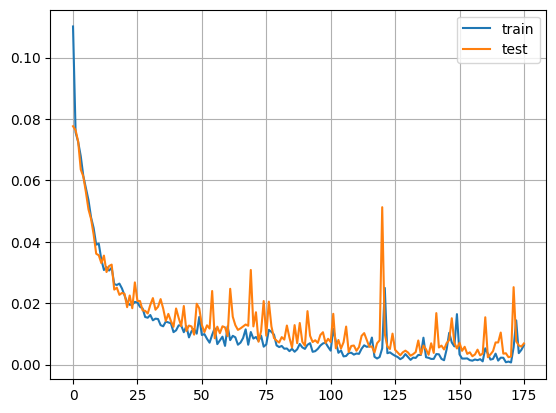

In [81]:
# plot training history
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.show()

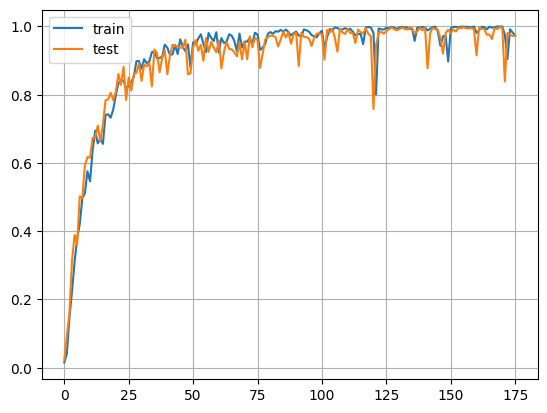

In [82]:
# plot training history
plt.plot(model_history.history['prc'], label='train')
plt.plot(model_history.history['val_prc'], label='test')
plt.legend()
plt.grid()
plt.show()

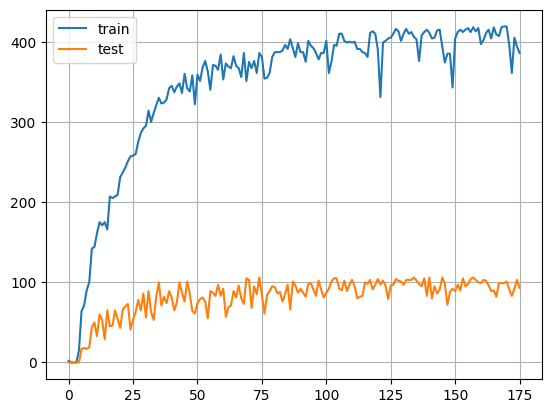

In [83]:
# plot training history
plt.plot(model_history.history['tp'], label='train')
plt.plot(model_history.history['val_tp'], label='test')
plt.legend()
plt.grid()
plt.show()

In [84]:
y_test_pred = model.predict(X_test)

217/217 [==============================] - 0s 665us/step


In [85]:
print("Perfect confusion matrix")
print(confusion_matrix(y_test, y_test > 0.5))

Perfect confusion matrix
[[6824    0]
 [   0  106]]


In [86]:
print('AUPRC',average_precision_score(y_test, y_test_pred))
print('AUROC',roc_auc_score(y_test, y_test_pred))

print()
print(confusion_matrix(y_test, y_test_pred > 0.5))

AUPRC 0.9980672174187606
AUROC 0.9999709681700546

[[6823    1]
 [   8   98]]


In [87]:
print(classification_report(y_test, y_test_pred > 0.5))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6824
         1.0       0.99      0.92      0.96       106

    accuracy                           1.00      6930
   macro avg       0.99      0.96      0.98      6930
weighted avg       1.00      1.00      1.00      6930



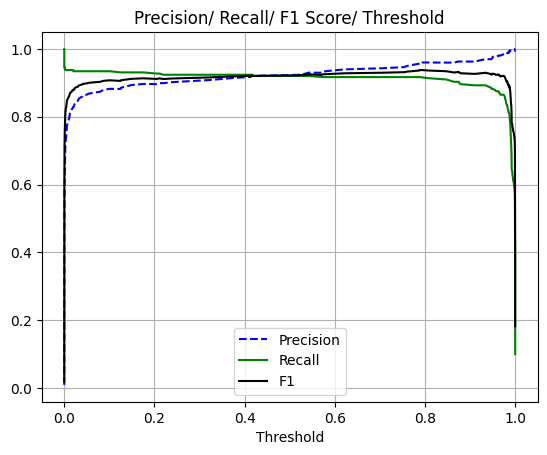

In [36]:
plot_precision_recall_vs_threshold(y_test, y_test_pred)

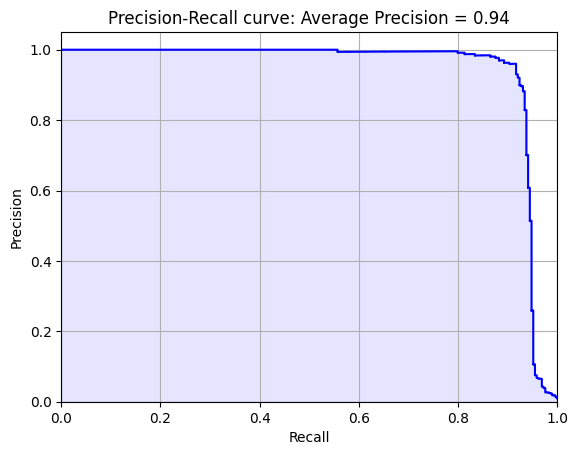

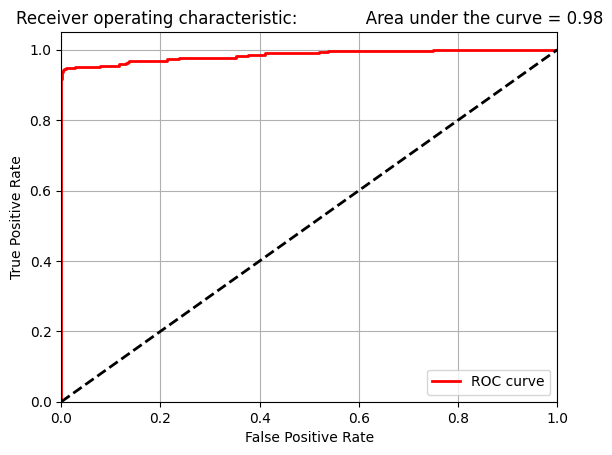

In [37]:
plot_prc_and_roc(y_test, y_test_pred)

In [38]:
get_scores_thresholds(X_test, y_test, model, algo="DNN")


931/931 [==============================] - 0s 320us/step
threshold: 0.1
[[29442    36]
 [   19   270]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29478
         1.0       0.88      0.93      0.91       289

    accuracy                           1.00     29767
   macro avg       0.94      0.97      0.95     29767
weighted avg       1.00      1.00      1.00     29767

--------------------------------------
931/931 [==============================] - 0s 382us/step
threshold: 0.2
[[29447    31]
 [   21   268]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29478
         1.0       0.90      0.93      0.91       289

    accuracy                           1.00     29767
   macro avg       0.95      0.96      0.96     29767
weighted avg       1.00      1.00      1.00     29767

--------------------------------------
931/931 [==============================] - 0s 285us/step
thres

In [39]:
# model.save('robot_2')

### Re-fit on whole data!

In [40]:
n_inputs = X.shape[1]  # (77862, 3)
print('Input shape',n_inputs)
model = make_model(n_inputs, metrics=METRICS)

Input shape 500


In [41]:
EPOCHS=50 #200
BATCH_SIZE=512# 2048
final_history = model.fit(X, y,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=1,
                          shuffle=True) 

Epoch 1/50
291/291 [==============================] - 1s 2ms/step - loss: 0.0831 - tp: 769.0000 - fp: 2076.0000 - tn: 174789.0000 - fn: 964.0000 - precision: 0.2703 - recall: 0.4437 - auc: 0.8201 - prc: 0.3484
Epoch 2/50
291/291 [==============================] - 0s 1ms/step - loss: 0.0295 - tp: 764.0000 - fp: 106.0000 - tn: 147281.0000 - fn: 680.0000 - precision: 0.8782 - recall: 0.5291 - auc: 0.9272 - prc: 0.6187
Epoch 3/50
291/291 [==============================] - 0s 2ms/step - loss: 0.0172 - tp: 1020.0000 - fp: 137.0000 - tn: 147250.0000 - fn: 424.0000 - precision: 0.8816 - recall: 0.7064 - auc: 0.9617 - prc: 0.7867
Epoch 4/50
291/291 [==============================] - 0s 2ms/step - loss: 0.0109 - tp: 1180.0000 - fp: 118.0000 - tn: 147269.0000 - fn: 264.0000 - precision: 0.9091 - recall: 0.8172 - auc: 0.9793 - prc: 0.8719
Epoch 5/50
291/291 [==============================] - 1s 2ms/step - loss: 0.0097 - tp: 1212.0000 - fp: 121.0000 - tn: 147266.0000 - fn: 232.0000 - precision: 0.9

291/291 [==============================] - 1s 2ms/step - loss: 0.0020 - tp: 1399.0000 - fp: 50.0000 - tn: 147337.0000 - fn: 45.0000 - precision: 0.9655 - recall: 0.9688 - auc: 0.9996 - prc: 0.9886
Epoch 41/50
291/291 [==============================] - 0s 2ms/step - loss: 0.0013 - tp: 1419.0000 - fp: 28.0000 - tn: 147359.0000 - fn: 25.0000 - precision: 0.9806 - recall: 0.9827 - auc: 0.9996 - prc: 0.9972
Epoch 42/50
291/291 [==============================] - 1s 3ms/step - loss: 0.0015 - tp: 1405.0000 - fp: 43.0000 - tn: 147344.0000 - fn: 39.0000 - precision: 0.9703 - recall: 0.9730 - auc: 0.9996 - prc: 0.9941
Epoch 43/50
291/291 [==============================] - 1s 2ms/step - loss: 0.0011 - tp: 1414.0000 - fp: 34.0000 - tn: 147353.0000 - fn: 30.0000 - precision: 0.9765 - recall: 0.9792 - auc: 1.0000 - prc: 0.9966
Epoch 44/50
291/291 [==============================] - 1s 2ms/step - loss: 0.0014 - tp: 1411.0000 - fp: 36.0000 - tn: 147351.0000 - fn: 33.0000 - precision: 0.9751 - recall: 0.

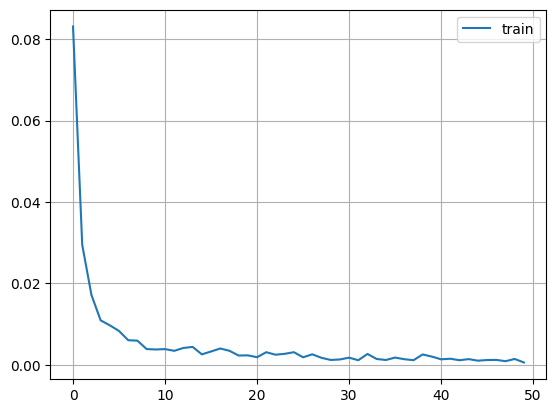

In [45]:
# plot training history
plt.plot(final_history.history['loss'], label='train')
plt.legend()
plt.grid()
plt.show()

In [44]:
# model.save('sim_3_full')

INFO:tensorflow:Assets written to: sim_3_full/assets


INFO:tensorflow:Assets written to: sim_3_full/assets


In [88]:
model = keras.models.load_model('./robot_1_full')


In [89]:
y_predict = model.predict(X)

1083/1083 [==============================] - 0s 303us/step


In [90]:
print(confusion_matrix(y, y > 0.5))

[[34118     0]
 [    0   528]]


In [93]:
print(confusion_matrix(y, y_predict > 0.5))

[[34102    16]
 [    8   520]]


In [94]:
print(confusion_matrix(y, y_predict > 0.8))

[[34115     3]
 [   32   496]]


In [92]:
y.sum()

528.0